# L-RVGA

The Limited-memory Recursive Variational Gaussian Approximation equations are given by

$$
\begin{aligned}
    q^*_t(\theta) &= \arg\min_{\mu^*, P^*}
        \text{KL}\left(  \mathcal{N}(\theta \vert \mu^*, P^*)  || \mathcal{N}(\theta \vert \mu_{t-1}, P_{t-1}^{-1}) p(y_t \vert\theta) \right)\\
    q_t(\theta) &= \arg\min_{\mu, W, \Psi}
         \text{KL}\left( \mathcal{N}(\theta \vert \left(WW^T + \Psi\right)^{-1} || \mathcal{N}(\theta \vert \mu^*, P^*)   \right)
\end{aligned}
$$

## R-VGA for a linear model

We consider the case for a linear model of the form $y_t = x_t^T\theta + \epsilon_t$, where $\epsilon_t\sim\mathcal{N}(0, \sigma_\epsilon^2)$. If we set $\sigma_\epsilon^2 = 1$, the R-VGA equations are given by

$$
\begin{aligned}
    \mu_t &= \mu_{t-1} + P_t x_t (y_t - \mu_{t-1}x_t)\\
    P_t &= P_{t-1} - x_tx_t^T
\end{aligned}
$$

In [1]:
import jax
import chex
import jax.numpy  as jnp
import matplotlib.pyplot as plt
from functools import partial
from jaxtyping import Array, Float, Int

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(314)
key_x, key_y = jax.random.split(key, 2)

In [4]:
@partial(jax.vmap, in_axes=(0, None, None))
def rmse(state, X, y):
    yhat = jnp.einsum("m,nm->n", state.mu, X)
    loss = jnp.power(y - yhat, 2).mean()
    return loss


@chex.dataclass
class LMState:
    mu: Float[Array, "obs_dim"]
    Pinv: Float[Array, "obs_dim obs_dim"]


def rvga_update(state:LMState, obs):
    """
    Perform a Recursive Variational Gaussian Approximation
    step for a linear model of the form y=w^T*x + eps
    """
    mu = state.mu
    Pinv = state.Pinv
    
    P = jnp.linalg.inv(Pinv)
    x, y = obs
    
    mu = mu + P @ x @ (y - mu @ x)
    Pinv = Pinv + x @ x.T
    
    state_new = LMState(mu=mu, Pinv=Pinv)
    
    return state_new, state_new

### Training / test dataset

In [5]:
n_train = 250
n_test = 50
n_total = n_train + n_test
xvals = jax.random.uniform(key_x, (n_total, 1), minval=-2, maxval=2)

theta = jnp.array([2.0])
eps_vals = jax.random.normal(key_y, (n_total,))
yvals = jnp.einsum("m,nm->n", theta, xvals) + eps_vals


xvals_test = xvals[-n_test:]
yvals_test = yvals[-n_test:]

xvals = xvals[:-n_test]
yvals = yvals[:-n_test]

ix_sort = jnp.argsort(yvals)
xvals = xvals[ix_sort]
yvals = yvals[ix_sort]

### Running R-VGA

In [6]:
Pinv0 = jnp.eye(1) * 1
mu0 = jnp.array([0.0])
state0 = LMState(mu=mu0, Pinv=Pinv0)

D = (xvals, yvals[:, None])

state, hist = jax.lax.scan(rvga_update, state0, D)

In [7]:
skip = 10
range_test = jnp.arange(skip + 1, n_train + 1)

Text(0.5, 1.0, 'RMSE')

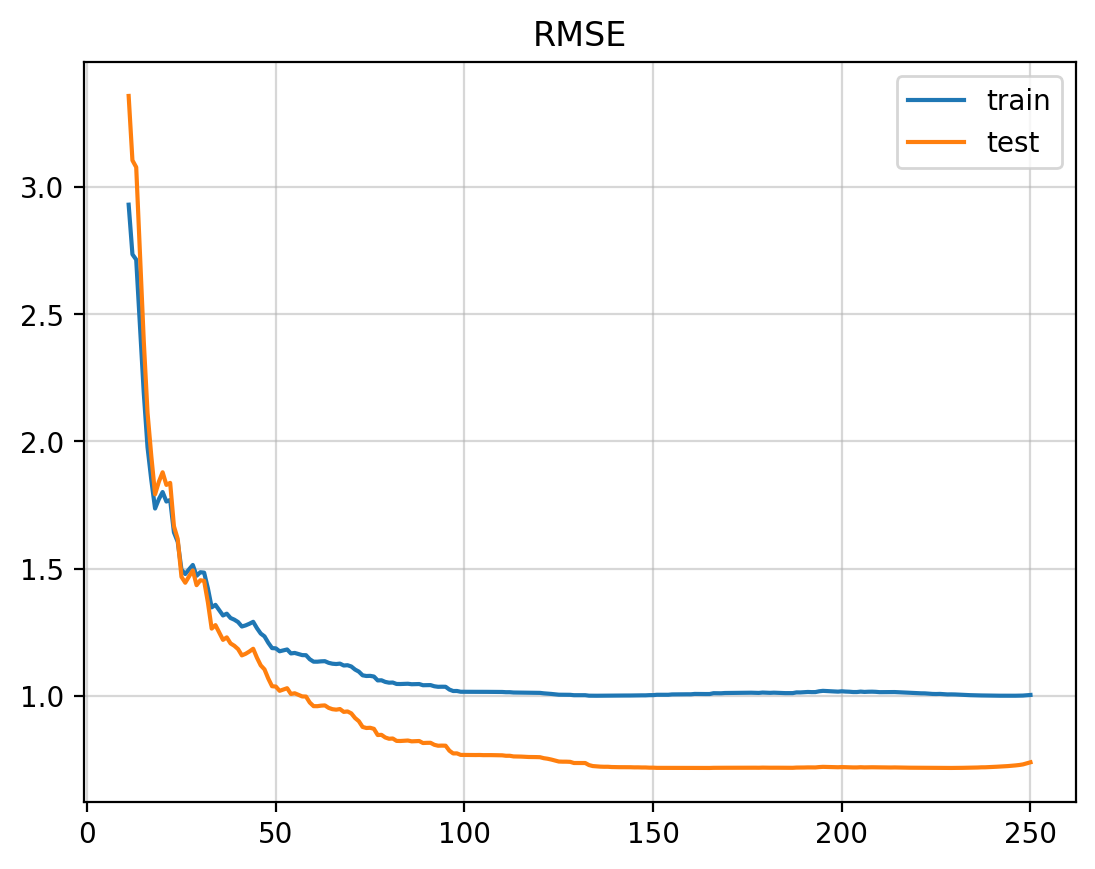

In [8]:
rmse_vals_test = rmse(hist, xvals_test, yvals_test)
rmse_vals_train = rmse(hist, xvals, yvals)

plt.plot(range_test, rmse_vals_train[skip:], label="train")
plt.plot(range_test, rmse_vals_test[skip:], label="test")
plt.legend()
plt.grid(alpha=0.5)
plt.title("RMSE")

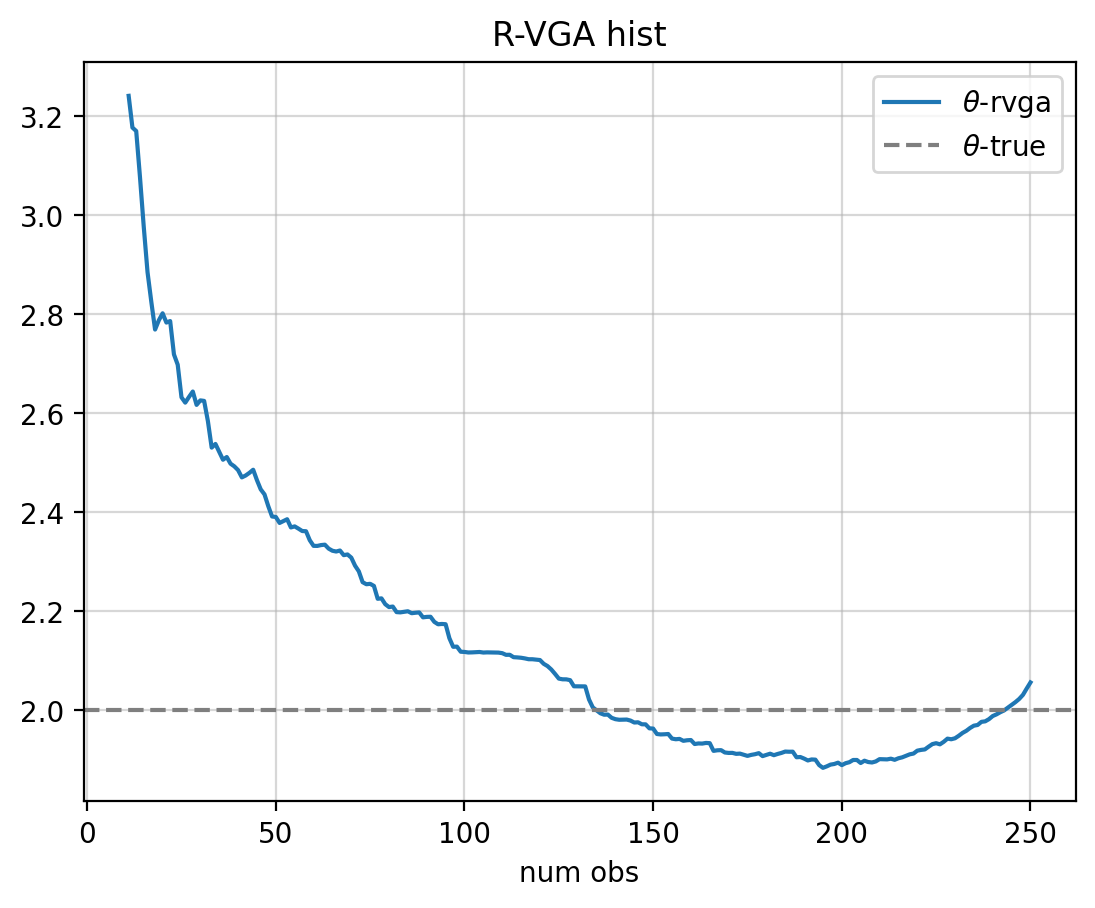

In [9]:
plt.plot(range_test, hist["mu"][skip:], label=r"$\theta$-rvga")
plt.axhline(y=2.0, c="tab:gray", linestyle="--", label=r"$\theta$-true")
plt.xlabel("num obs")
plt.legend()
plt.title("R-VGA hist")
plt.grid(alpha=0.5)

## L-RVGA